In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import eli5 # for permutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots # for partial plots
np.random.seed(123) # ensure reproducibility
import numpy.core.multiarray
pd.options.mode.chained_assignment = None #hide any pandas warnings

In [125]:
dt = pd.read_csv("heart.csv")

In [126]:
dt.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [127]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [128]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

In [129]:
dt.head(3)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,non-anginal pain,145,233,greater than 120mg/ml,normal,150,no,2.3,0,0,normal,1
1,37,male,atypical angina,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,0,0,fixed defect,1
2,41,female,typical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,flat,0,fixed defect,1


In [130]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')



In [131]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [132]:
dt = pd.get_dummies(dt, drop_first=True)

In [133]:
dt.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0


In [134]:
X_train , X_test , y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10)

In [135]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [136]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [137]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [138]:
y_pred_bin = model.predict(X_test)

In [139]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[28,  7],
       [ 3, 23]], dtype=int64)

In [140]:
total = sum(sum(confusion_matrix))
sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('senstivity :', sensitivity)

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity :', specificity)

senstivity : 0.9032258064516129
Specificity : 0.7666666666666667


In [141]:
y_pred_quant

array([0.11714286, 0.35507246, 0.16785714, 0.70238756, 0.18443651,
       0.89120336, 0.61660957, 0.78051943, 0.94471832, 0.05119048,
       0.95805165, 0.00555556, 0.82286375, 0.99152778, 0.30444444,
       0.86236715, 0.17896825, 0.00952381, 0.71362319, 0.25015183,
       0.12380952, 0.86846541, 0.57430188, 0.92186813, 0.35191198,
       0.08952381, 0.00952381, 0.16857864, 0.81827624, 0.        ,
       0.80248677, 0.30729469, 0.2       , 0.51124622, 0.00952381,
       0.06459627, 0.56661679, 0.46138889, 0.92080026, 0.38873016,
       0.        , 0.34235335, 0.92829232, 0.42047619, 0.97180165,
       0.18886364, 0.54285714, 0.8552378 , 0.91319444, 0.31014493,
       0.6375    , 0.74885046, 0.02564103, 0.24788199, 0.96872804,
       0.85123769, 0.78472222, 0.8238947 , 0.00952381, 0.01428571,
       0.71849332])

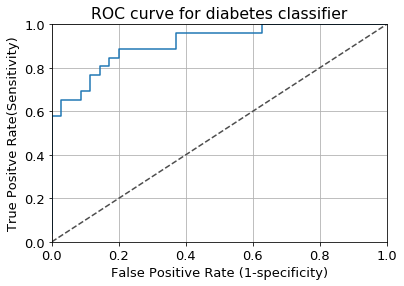

In [142]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], transform = ax.transAxes, ls='--', c= ".3" )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size']=13
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1-specificity)')
plt.ylabel('True Positve Rate(Sensitivity)')
plt.grid(True)


In [143]:
auc(fpr, tpr)

0.9131868131868133

In [144]:
# Permutation importance is used for understanding a machine learning model and involves shuffling individual variables invalidation data, afetr the model has been fit and seeing the effect on accuracy

In [145]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())


Weight,Feature
0.0754 ± 0.0445,thalassemia_reversable defect
0.0459 ± 0.0321,max_heart_rate_achieved
0.0393 ± 0.0334,num_major_vessels
0.0295 ± 0.0245,st_depression
0.0197 ± 0.0382,thalassemia_fixed defect
0.0197 ± 0.0245,rest_ecg_normal
0.0164 ± 0.0000,exercise_induced_angina_yes
0.0131 ± 0.0131,sex_male
0.0131 ± 0.0131,cholesterol
0.0066 ± 0.0334,age


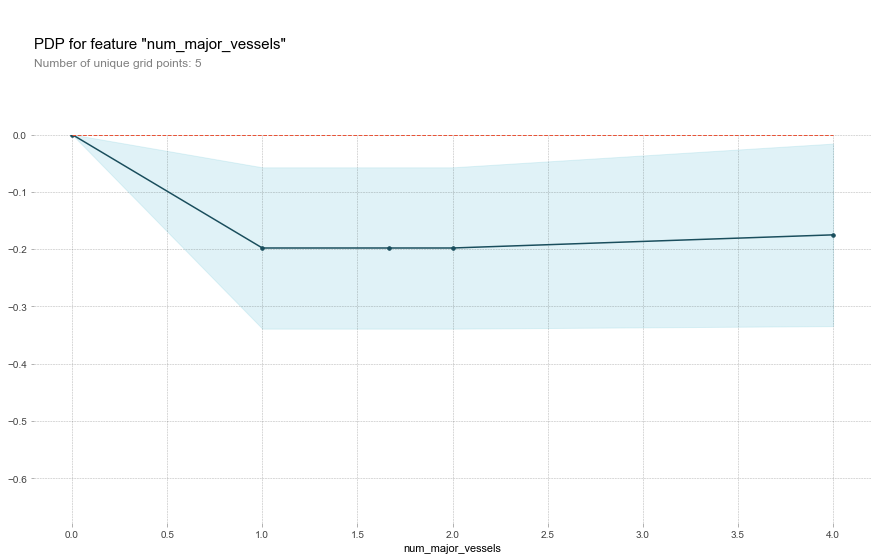

In [146]:
# partial dependence plot

base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'

pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

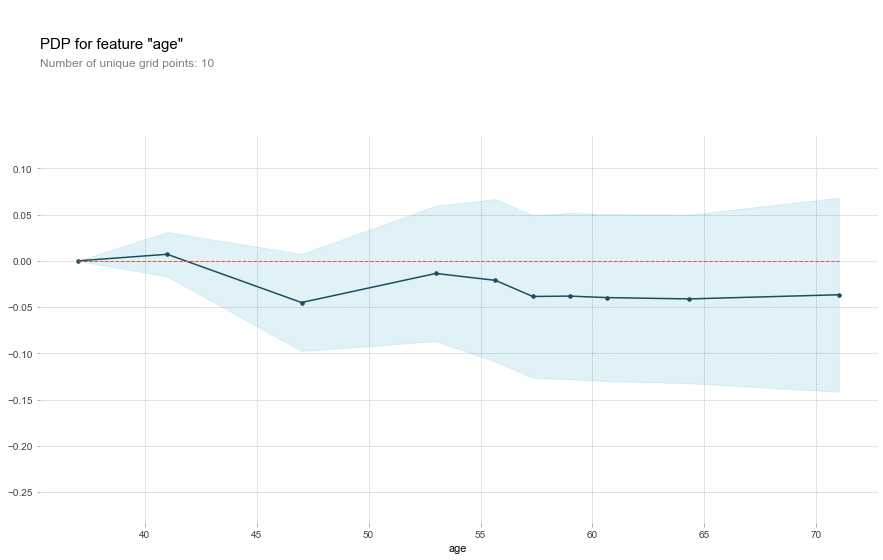

In [157]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

